In [1]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable
import random
import torchvision
import torchvision.transforms as transforms
from source.utils import Class_Dataset
from tqdm import tqdm
from source.neural_integral_operator import integral_operator
from source.models import G_global
from source.integrators import MonteCarlo

use_cuda = torch.cuda.is_available()

In [2]:
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"

In [3]:
dim = 2
batch_size = 16
mc = MonteCarlo()
mc_samplings=2000
enc_dim = 16

In [4]:
encoder = torch.nn.Conv1d(
    1,
    enc_dim+1,
    [16],
    stride=8,
    ).to(device)

In [5]:
shapes = encoder(torch.rand(batch_size,235,1).permute(0,2,1).to(device)).shape

In [6]:
shapes

torch.Size([16, 17, 28])

In [7]:
times = torch.linspace(0,1,shapes[2])

In [8]:
G = G_global(enc_dim,2,[128,128,128]).to(device)

In [9]:
model = integral_operator(dim, times, G, mc, num_internal_points=times.shape[0],mc_samplings=mc_samplings).to(device)

In [10]:
import mat73

In [11]:
X = mat73.loadmat('MIR_Fruit_Purees.mat')

In [12]:
Data = torch.from_numpy(X['X']).unsqueeze(-1)

In [13]:
#Data = torch.nn.functional.normalize(Data,p=153).to(device)

In [14]:
# Calculate min and max for each feature
data_min = Data.min(dim=0)[0]
data_max = Data.max(dim=0)[0]

# Min-Max Scaling
Data = (Data - data_min) / (data_max - data_min)

In [15]:
Cls = torch.from_numpy(X['class']) - 1

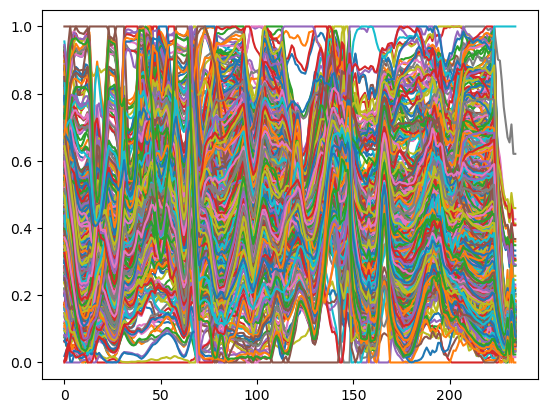

In [16]:
#Visualize
for i in range(Data.shape[0]):
    plt.plot(Data[i,:,0].cpu())
    plt.show

In [17]:
Data.shape

torch.Size([983, 235, 1])

In [18]:
Cls = Cls.type(torch.LongTensor).to(device)

In [19]:
zeros = 0
ones = 0
for i in range(Cls.shape[0]):
    if Cls[i] == 0:
        zeros += 1
    else:
        ones += 1
print(zeros, ones)

351 632


In [20]:
permutation = torch.randperm(Data.shape[0])
print(permutation)

tensor([764, 601, 893, 369, 304, 833, 590, 189,   6, 636, 260, 885, 688, 181,
        829, 980, 698, 854, 490, 557, 114, 949,  74, 812, 656, 832, 556, 886,
         34, 524, 866,  68, 923, 810, 850, 624, 697, 824, 840, 308, 488, 853,
        678, 862, 538, 772, 970, 694, 314, 768, 696, 646, 445, 603, 809, 799,
        958, 827, 459, 244, 462,  12, 289, 865,  46, 798, 876, 427, 237, 165,
         89,  69, 194, 756, 508, 476,  66, 243, 513, 713, 660, 572,  53, 421,
        757, 569, 559, 291, 505, 561, 112, 786, 648,  23, 771, 763, 249, 825,
        410, 769, 629, 208, 152,   5, 904, 338, 550, 141, 463, 754,  24, 817,
        837, 715, 814, 198, 762, 526, 332, 160, 214, 432,  60, 755, 200,  51,
        805, 911, 746, 634, 706, 264, 963, 637, 540, 555, 797, 848,  14, 121,
        161, 890, 247, 807, 528,  72, 159, 392, 916, 222, 471, 469, 385, 271,
        847, 928, 248, 859, 140, 950, 895, 185, 148, 426, 142, 839, 683,  63,
        158, 701, 795, 638, 910, 594, 472, 774, 940, 342, 574, 5

In [21]:
Data = Data[permutation,...]
Cls = Cls[permutation,...]

In [22]:
Data_train = Data[:-192,...].to(device)
Cls_train = Cls[:-192,...].to(device)
Data_val = Data[-192:-96,...].to(device)
Cls_val = Cls[-192:-96,...].to(device)
    
Data_test = Data[-96:,...].to(device)
Cls_test = Cls[-96:,...].to(device)

In [23]:
# Data_train_ = torch.tensor([]).to(device)
# Cls_train_ = torch.tensor([]).type(torch.LongTensor).to(device)
# Data_test = torch.tensor([]).to(device)
# Cls_test = torch.tensor([]).type(torch.LongTensor).to(device)
# counter_zero_train = 0
# counter_one_train = 0
# counter_zero_test = 0
# counter_one_test = 0

# for i in range(Data.shape[0]):
#     if Cls[i] == 0 and counter_zero_train<301:
#        Data_train_ = torch.cat([Data_train_,Data[i:i+1]],0)
#        Cls_train_ = torch.cat([Cls_train_,Cls[i:i+1]],0) 
#        counter_zero_train += 1
#     elif Cls[i] == 1 and counter_one_train<301:
#        Data_train_ = torch.cat([Data_train_,Data[i:i+1]],0)
#        Cls_train_ = torch.cat([Cls_train_,Cls[i:i+1]],0) 
#        counter_one_train += 1
#     elif Cls[i] == 0 and counter_zero_test<52:
#        Data_test = torch.cat([Data_test,Data[i:i+1]],0)
#        Cls_test = torch.cat([Cls_test,Cls[i:i+1]],0) 
#        counter_zero_test += 1
#     elif Cls[i] == 1 and counter_one_test<52:
#        Data_test = torch.cat([Data_test,Data[i:i+1]],0)
#        Cls_test = torch.cat([Cls_test,Cls[i:i+1]],0) 
#        counter_one_test += 1
# print(Data_train_.shape, Data_test.shape, Cls_train_.shape, Cls_test.shape)

In [24]:
# permutation2 = torch.randperm(Data_train_.shape[0])

# Data_train_ = Data_train_[permutation2,...]
# Cls_train_ = Cls_train_[permutation2,...]

# Data_train = Data_train_[:-80,...]
# Cls_train = Cls_train_[:-80,...]
# Data_val = Data_train_[-80:,...]
# Cls_val = Cls_train_[-80:,...]

In [25]:
zeros = 0
ones = 0
for i in range(Cls_val.shape[0]):
    if Cls_val[i] == 0:
        zeros += 1
    else:
        ones += 1
print(zeros, ones)

38 58


In [26]:
zeros = 0
ones = 0
for i in range(Cls_train.shape[0]):
    if Cls_train[i] == 0:
        zeros += 1
    else:
        ones += 1
print(zeros, ones)

279 512


In [27]:
zeros = 0
ones = 0
for i in range(Cls_test.shape[0]):
    if Cls_test[i] == 0:
        zeros += 1
    else:
        ones += 1
print(zeros, ones)

34 62


In [28]:

train_loader = torch.utils.data.DataLoader(
                                   Class_Dataset(Data_train, Cls_train),
                                   batch_size=batch_size, 
                                   shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
                                   Class_Dataset(Data_val, Cls_val),
                                   batch_size=batch_size, 
                                   shuffle=False
)

test_loader = torch.utils.data.DataLoader(
                                   Class_Dataset(Data_test, Cls_test), 
                                   batch_size=1,
                                   shuffle=False
)


# if args.mode == 'train':
#     dataloaders = {'train': train_loader,
#                    'val': valid_loader,
#                   }
# else:
#     dataloaders = {
#                    'test': test_loader,
#                   }

In [29]:
torch.save(test_loader, 'loader_test_fruit')

In [30]:
def flatten_kernel_parameters(kernel):
    p_shapes = []
    flat_parameters = []
    for p in kernel.parameters():
        p_shapes.append(p.size())
        flat_parameters.append(p.flatten())
    return torch.cat(flat_parameters)

In [31]:
flatten_kernel_parameters(model).shape[0] + flatten_kernel_parameters(encoder).shape[0]

36003

In [32]:
patience = 50
factor = 0.5

In [33]:
All_parameters = list(model.parameters()) + list(encoder.parameters())
optimizer = torch.optim.Adam(All_parameters, lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = \
torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=101, eta_min=1e-7)
#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, min_lr=1e-9,factor=factor)
warmup = 7

In [34]:
epochs = 3000

In [35]:
len(train_loader)

50

In [36]:
verbose = False
losses = []
best_loss = np.inf
all_val_loss = []

for i in range(epochs):
    print("Epoch:", i)
    
    tot_loss = 0.
    counter = 0
    for  spectra, labels in tqdm(train_loader):

        if verbose: print(spectra.shape)
        spectra = spectra
        if verbose: print(spectra.shape)

        encoded = encoder(spectra.permute(0,2,1)).permute(0,2,1)
        inputs, x = encoded[...,:-1], encoded[:,-1,-1:]
        
        outputs = model(inputs,x)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tot_loss += loss.item()
        counter += 1

        if verbose and i % 20 == 0:
            print(loss.item())
    
    losses.append(tot_loss/counter)


    with torch.no_grad():
        counter = 0
        val_loss = 0.
    for  spectra, labels in tqdm(valid_loader):

        if verbose: print(spectra.shape)
        spectra = spectra
        if verbose: print(spectra.shape)

        encoded = encoder(spectra.permute(0,2,1)).permute(0,2,1)
        inputs, x = encoded[...,:-1], encoded[:,-1,-1:]
        outputs = model(inputs,x)
        
        loss_validation = criterion(outputs, labels)

        counter += 1
        val_loss += loss_validation.item()
        

    if i > warmup:
        scheduler.step(val_loss/counter)
    all_val_loss.append(val_loss/counter)  

    plt.figure(0, figsize=(8,8),facecolor='w')           
    plt.plot(np.log10(losses),label='Train loss')
    plt.plot(np.log10(all_val_loss),label='Val loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.savefig('losses')
    plt.close()


    if all_val_loss[-1] < best_loss:
        print('Saving for epoch: ', i, all_val_loss[-1])
        torch.save(G,'kernel')
        torch.save(encoder,'encoder')
        best_loss = all_val_loss[-1]

Epoch: 0


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])


 12%|█▏        | 6/50 [00:00<00:02, 17.50it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 42%|████▏     | 21/50 [00:00<00:00, 38.61it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 52%|█████▏    | 26/50 [00:00<00:00, 41.70it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 72%|███████▏  | 36/50 [00:01<00:00, 45.49it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


100%|██████████| 50/50 [00:01<00:00, 37.81it/s]


torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([7, 28, 16]) torch.Size([7, 1])


100%|██████████| 6/6 [00:00<00:00, 74.66it/s]


Saving for epoch:  0 0.6828834215799967
Epoch: 1


 12%|█▏        | 6/50 [00:00<00:00, 52.27it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 34%|███▍      | 17/50 [00:00<00:00, 48.94it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 54%|█████▍    | 27/50 [00:00<00:00, 48.75it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 76%|███████▌  | 38/50 [00:00<00:00, 49.86it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 96%|█████████▌| 48/50 [00:00<00:00, 49.41it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


100%|██████████| 50/50 [00:01<00:00, 49.39it/s]


torch.Size([7, 28, 16]) torch.Size([7, 1])


100%|██████████| 6/6 [00:00<00:00, 67.86it/s]


Saving for epoch:  1 0.6780482629934946
Epoch: 2


  0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])


 12%|█▏        | 6/50 [00:00<00:00, 52.17it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 36%|███▌      | 18/50 [00:00<00:00, 49.87it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 60%|██████    | 30/50 [00:00<00:00, 51.41it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 84%|████████▍ | 42/50 [00:00<00:00, 51.48it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


100%|██████████| 50/50 [00:00<00:00, 50.92it/s]


torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([7, 28, 16]) torch.Size([7, 1])


100%|██████████| 6/6 [00:00<00:00, 70.70it/s]


Saving for epoch:  2 0.6710090637207031
Epoch: 3


 12%|█▏        | 6/50 [00:00<00:00, 51.07it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 36%|███▌      | 18/50 [00:00<00:00, 53.95it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 60%|██████    | 30/50 [00:00<00:00, 54.00it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 84%|████████▍ | 42/50 [00:00<00:00, 51.47it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


100%|██████████| 50/50 [00:00<00:00, 53.36it/s]


torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([7, 28, 16]) torch.Size([7, 1])


100%|██████████| 6/6 [00:00<00:00, 89.46it/s]


Saving for epoch:  3 0.6526245673497518
Epoch: 4


 12%|█▏        | 6/50 [00:00<00:00, 51.55it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 36%|███▌      | 18/50 [00:00<00:00, 54.24it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 60%|██████    | 30/50 [00:00<00:00, 55.21it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 84%|████████▍ | 42/50 [00:00<00:00, 55.89it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


100%|██████████| 50/50 [00:00<00:00, 54.99it/s]


torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([7, 28, 16]) torch.Size([7, 1])


100%|██████████| 6/6 [00:00<00:00, 89.09it/s]


Epoch: 5


 12%|█▏        | 6/50 [00:00<00:00, 49.23it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 36%|███▌      | 18/50 [00:00<00:00, 53.72it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 60%|██████    | 30/50 [00:00<00:00, 54.78it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 84%|████████▍ | 42/50 [00:00<00:00, 54.62it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


100%|██████████| 50/50 [00:00<00:00, 54.63it/s]


torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([7, 28, 16]) torch.Size([7, 1])


100%|██████████| 6/6 [00:00<00:00, 89.34it/s]


Saving for epoch:  5 0.6337631891171137
Epoch: 6


 12%|█▏        | 6/50 [00:00<00:00, 51.90it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 36%|███▌      | 18/50 [00:00<00:00, 54.46it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 60%|██████    | 30/50 [00:00<00:00, 54.82it/s]

torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


 76%|███████▌  | 38/50 [00:00<00:00, 53.54it/s]


torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])
torch.Size([16, 28, 16]) torch.Size([16, 1])


KeyboardInterrupt: 

In [ ]:
test_loader = torch.load('loader_test_fruit')

In [ ]:
len(test_loader)

In [ ]:
G = torch.load('kernel').to(device)
encoder = torch.load('encoder').to(device)

In [ ]:
model = integral_operator(dim, times, G, mc, num_internal_points=times.shape[0],mc_samplings=2000).to(device)

In [ ]:
tot_predicted = torch.tensor([]).to(device)
tot_labels = torch.tensor([]).to(device)
tot_outputs = torch.tensor([]).to(device)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for spectra, labels in tqdm(test_loader):
        spectra = spectra

        encoded = encoder(spectra.permute(0,2,1)).permute(0,2,1)
        inputs, x = encoded[...,:-1], encoded[:,-1,-1:]
        outputs = model(inputs,x)
        tot_outputs = torch.cat([tot_outputs,outputs],0)
        
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item() 
        
        tot_predicted = torch.cat([tot_predicted,predicted], dim=0)
        tot_labels = torch.cat([tot_labels, labels], dim=0)

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy: {acc} %')

In [ ]:
softmax = torch.nn.Softmax(dim=1)

In [ ]:
softmax(tot_outputs)

In [ ]:
from sklearn.metrics import r2_score
r2_score(tot_labels.cpu(),tot_predicted.cpu())

In [ ]:
from sklearn.metrics import classification_report
classification_report(tot_labels.cpu(),tot_predicted.cpu())